<a href="https://colab.research.google.com/github/LeonMilosevic/home_credit/blob/main/home_credit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Home Credit Default Risk Competition

### Intro

Introduction: \

https://www.kaggle.com/c/home-credit-default-risk/overview

In Home Credit Default Risk Competition we need to make a model, that will give us a probability that the given client repays the loan. This should help the business decide if they should or should not proivde financial loan to a given customer.

Problem:

It is a binary classification problem:
- Will repay the loan = 0
- Will not repay the loan = 1

Evaluation Criteria:

Based on the requirements of the competition, we will need to evaluate our models on ***roc_auc_score*** metric.

Data:

- application_{train|test}.csv (main file)
- bureau.csv
- bureau_balance.csv
- POS_CASH_balance.csv
- credit_card_balance.csv
- previous_application.csv
- installments_payments.csv
- HomeCredit_columns_description.csv

Approach:
- Explore the data of application_train
- Create baseline model
- Improve the model with feature engineering
- Explore other files
- Add usefull features from other files
- Test models on new features
- Feature Engineering
- Hyperparametar Tuning
- Feature Impotrance

Imports

In [ ]:
!pip install catboost

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import missingno as msno
from scipy import stats

from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import roc_auc_score

from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split

Files

In [76]:
app_train = pd.read_csv('application_train.csv')
app_test = pd.read_csv('application_test.csv')
categorical_vars_data = pd.read_csv('categorical_vars.csv')
model_experiments = pd.read_csv('model_experiments.csv')

In [5]:
app_train.shape

(307511, 122)

In [6]:
app_test.shape

(48744, 121)

In [ ]:
app_train.head(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


Custom Functions

In [7]:
def check_missing_values(df: pd.DataFrame) -> pd.DataFrame:
  """Checks for missing values in the dataframe

    Args:
        df (pd.DataFrame): DataFrame to be scanned for missing values
    Returns:
        Dataframe of features that are mostly missing with percentage and total count
  """
  total = df.isnull().sum().sort_values(ascending=False)
  percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending=False)

  return pd.concat([total, percent], axis=1, keys=['total', 'percent'])

def chi_test_missing_data(cols: list, df: pd.DataFrame) -> list:
  """Performs a chi test on given columns

    Args:
        cols (list) : list of columns to be tested
        df (pd.DataFrame): DataFrame to be copied
    Returns:
        p_results (list) : list of p_values in order of columns given
  """
  p_results = []

  for col in cols:
    df_temp = df.copy()

    df_temp['has_missing_column_test'] = 0
    df_temp.loc[df_temp[col].isnull(), 'has_missing_column_test'] = 1

    chi_test = stats.chi2_contingency(pd.crosstab(df_temp.has_missing_column_test, df_temp.TARGET))

    p_results.append(chi_test[1])
  
  return p_results

### Missing Values

In [10]:
missing_values = check_missing_values(app_train)
missing_values[:50]

,total,percent
COMMONAREA_MEDI,214865,0.698723
COMMONAREA_AVG,214865,0.698723
COMMONAREA_MODE,214865,0.698723
NONLIVINGAPARTMENTS_MODE,213514,0.694330
NONLIVINGAPARTMENTS_MEDI,213514,0.694330
NONLIVINGAPARTMENTS_AVG,213514,0.694330
FONDKAPREMONT_MODE,210295,0.683862
LIVINGAPARTMENTS_MEDI,210199,0.683550
LIVINGAPARTMENTS_MODE,210199,0.683550
LIVINGAPARTMENTS_AVG,210199,0.683550


In [ ]:
missing_values[50:70]

,total,percent
EXT_SOURCE_3,60965,0.198253
AMT_REQ_CREDIT_BUREAU_QRT,41519,0.135016
AMT_REQ_CREDIT_BUREAU_YEAR,41519,0.135016
AMT_REQ_CREDIT_BUREAU_WEEK,41519,0.135016
AMT_REQ_CREDIT_BUREAU_MON,41519,0.135016
AMT_REQ_CREDIT_BUREAU_DAY,41519,0.135016
AMT_REQ_CREDIT_BUREAU_HOUR,41519,0.135016
NAME_TYPE_SUITE,1292,0.004201
OBS_30_CNT_SOCIAL_CIRCLE,1021,0.003320
OBS_60_CNT_SOCIAL_CIRCLE,1021,0.003320


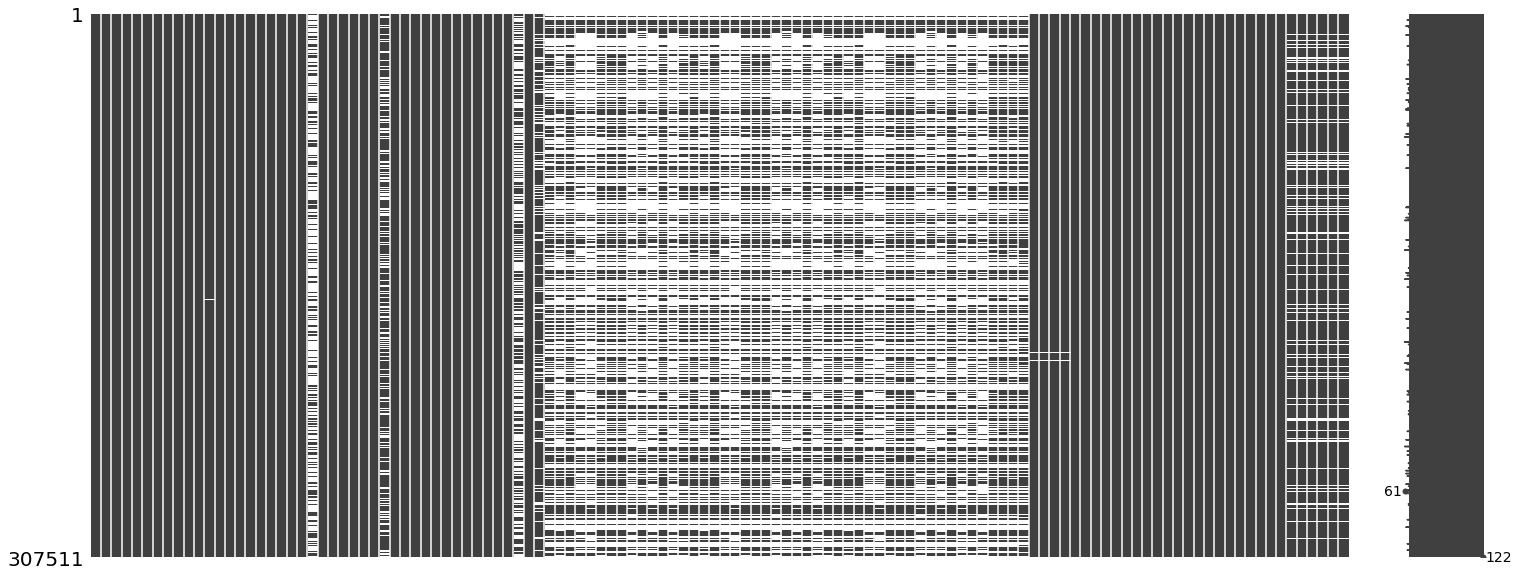

In [ ]:
msno.matrix(app_train)

**Missing Data Conclusions**: \
- Most of the data that has high percentage of missing values is house/apartment information

- According to Docs, missing values occured due to clients/clerks not filling them in, that can be either to clients not having an apartment or a house, or not having an apartment but having a house, or the opposite. It can also be due to not finding relevance in filling in those values. At this moment there is no way of determining if the client owns a house or an apartment and we cannot impute or flag the values with certainty. This is something we need to keep in mind for feature eng.

- OWN_CAR_AGE
- OCCUPATION_TYPE
- EXT_SOURCE_X comes from external source
- AMT_REQ_X did the client previously applied for a loan or not
- the rest is a very small percentage so we can impute it with a median value

###### Housing/Apartment missing values

We will use Chi-Square test do determain if there is a difference between clients who did not fill in housing/apartment values and clients who did.

H0: there is no difference between two groups \
H1: there is a difference between two groups \
Statistical Significance: 0.05 \

If there is a difference between two groups, we will add a flag feature to tell us weather the person has filled in apartment discription or not.


**Approach**: \
After consulting the documentation, there are 47 features describing the housing/apartment. \

We can assume that clients who own a house could've skipped filling in values for the apartment and vice versa, therefore we shouldn't check if a client didn't fill in 47 variables, we could lower the threshold to 35 since there are at least 9 variables that are indicating that the variable is only from apartment domain. 


In [11]:
non_housing_missing_features = ['OWN_CAR_AGE',
                                'EXT_SOURCE_1',
                                'OCCUPATION_TYPE']

housing_normalized_missing_features = list(set(missing_values[:50].index.tolist()) - set(non_housing_missing_features))

In [ ]:
chi_test_data = app_train.copy()

chi_test_data['has_missing_housing_info'] = 1
chi_test_data.loc[chi_test_data[housing_normalized_missing_features].isnull().sum(axis=1) < 35, 'has_missing_housing_info'] = 0
chi_test_data['has_missing_housing_info'].value_counts(normalize=True)

0    0.50179
1    0.49821
Name: has_missing_housing_info, dtype: float64

In [ ]:
pd.crosstab(chi_test_data.has_missing_housing_info, chi_test_data.TARGET)

TARGET,0,1
has_missing_housing_info,,
0,143556,10750
1,139130,14075


In [ ]:
chi_test = stats.chi2_contingency(pd.crosstab(chi_test_data.has_missing_housing_info, chi_test_data.TARGET))
p = chi_test[1]
if p < 0.05:
  print(p, " => reject H0")
else:
  print(p, " => fail to reject H0")

5.176020966832745e-113  => reject H0


Given that P value is less then our significance threshold , we can reject the null hypothesis saying that there is no difference between clients who fill in information, and clients who skip filling in information.

###### OWN_CAR_AGE variable

We will check if own_car_age was skipped due to the client not owning a car.

In [ ]:
app_train['OWN_CAR_AGE'].isnull().sum()

202929

In [ ]:
app_train[app_train['FLAG_OWN_CAR'] == 'N'].shape

(202924, 122)

In [ ]:
app_train[(app_train['FLAG_OWN_CAR'] == 'N') & (app_train['OWN_CAR_AGE'].isnull())].shape

(202924, 122)

In [ ]:
own_car_age_show = {'own_car_age_missing': [202929], 
                    'dont_own_car': [202924], 
                    'dont_own_car_and_own_car_age_missing': [202924], 
                    'own_car_and_car_age_missing': [6]}
own_car_age_df = pd.DataFrame(data=own_car_age_show)
own_car_age_df

,own_car_age_missing,dont_own_car,dont_own_car_and_own_car_age_missing,own_car_and_car_age_missing
0,202929,202924,202924,6


This is an interesting finding, all the clients that don't own a car have missing values for OWN_CAR_AGE variable. There are 6 clients who have a car but haven't filled in the OWN_CAR_AGE. 

###### OCCUPATION_TYPE, EXT_SOURCE_X variables

Lets us do the same test as with housing/apartment missing values, to know if we should flag the missing values in occupation. \

H0: there is no difference between two groups \
H1: there is a difference between two groups \
Statistical Significance: 0.05 \



In [ ]:
p_values = chi_test_missing_data(['OCCUPATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'], app_train)

for p in p_values:
  if p < 0.05:
    print(p, " => reject H0")
  else:
    print(p, " => fail to reject H0")

4.804746491614818e-102  => reject H0
5.139197205071727e-25  => reject H0
0.911047427710317  => fail to reject H0
4.8894679928311235e-36  => reject H0


#### Conclusion: 
**Appartment/Housing**: Reject the null hypothesis. \

**own_car_age**: There is a correlation between a client not owning a car and having NaN in own_car_age. \

**OCCUPATION_TYPE**: Reject the null hypothesis. \

**EXT_SOURCE_X**: \
**EXT_SOURCE_1**: reject the null hypothesis \
**EXT_SOURCE_2**: fail to reject the null hypothesis \
**EXT_SOURCE_3**: reject the null hypothesis \

**AMT_REQ_X**: We will deal with this after we start using different datasets, since we will be able to find information about it from different data.

### EDA

In [ ]:
app_train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,...,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,104582.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307509.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,134133.000000,3.068510e+05,246546.000000,151450.00000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,...,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,159080.000000,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,-4986.120328,-2994.202373,12.061091,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,2.152665,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,0.502130,5.143927e-01,0.510853,0.11744,0.088442,0.977735,0.752471,0.044621,0.078942,0.149725,0.226282,...,0.149213,0.225897,0.231625,0.067169,0.101954,0.108607,0.008651,0.028236,0.102547,1.422245,0.143421,1.405292,0.100049,-962.858788,0.000042,0.710023,0.000081,0.015115,0.088055,0.000192,0.081376,0.003896,0.000023,0.003912,0.000007,0.003525,0.002936,0.00121,0.009928,0.000267,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,3522.886321,1509.450419,11.944812,0.001803,0.384280,0.399526,0.043164,0.449521,0.231307,0.910682,0.509034,0.502737,3.265832,0.122126,0.219526,0.197499,0.268444,0.421124,0.383817,0.211062,1.910602e-01,0.194844,0.10824,0.082438,0.059223,0.113280,0.076036,0.134576,0.100049,0.144641,...,0.100368,0.145067,0.161934,0.082167,0.093642,0.112260,0.047415,0.070166,0.107462,2.400989,0.446698,2.379803,0.362291,826.808487,0.006502,0.453752,0.009016,0.122010,0.283376,0.013850,0.273412,0.062295,0.004771,0.062424,0.002550,0.059268,0.054110,

Looking at the Train Data briefly: \

We can see our target variable, it contains 0 and 1 values, with a mean of 0.08 and we can interpret that as a high class imbalance, we should explore it more.

There are encoded values with 0-1, we should consult documentation a bit later when we explore each feature more.

##### Explore target

In [ ]:
app_train['TARGET'].value_counts(normalize=True)

0    0.919271
1    0.080729
Name: TARGET, dtype: float64

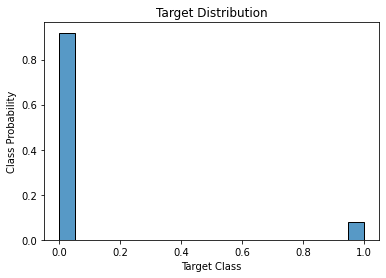

In [ ]:
ax = sns.histplot(app_train['TARGET'], stat='probability')
ax.set(xlabel="Target Class", ylabel='Class Probability', title="Target Distribution")
plt.show()

We will need to deal with class imbalance. We could use SMOTE to generate more data with target value as 1. When we are performing the train/test split, we should stratisfy the split based on our class ratio.

##### Explore Categorical vars

In [ ]:
app_train[app_train['NAME_FAMILY_STATUS']=='Unknown'].shape

(2, 122)

In [54]:
app_train['CODE_GENDER'].value_counts(normalize=True)

F      0.658344
M      0.341643
XNA    0.000013
Name: CODE_GENDER, dtype: float64

In [55]:
app_train.loc[app_train[app_train['CODE_GENDER'] == 'XNA'].index, 'CODE_GENDER'] = np.nan

In [62]:
categorical_vars_data.dropna()

,var_names,aproach
0,NAME_CONTRACT_TYPE,"one hot encode, 0-1"
1,CODE_GENDER,"one hot encode, 0-1"
2,FLAG_OWN_CAR,"one hot encode, 0-1"
3,FLAG_OWN_REALTY,"one hot encode, 0-1"
5,NAME_TYPE_SUITE,"one hot encode, 0-1"
6,NAME_INCOME_TYPE,"one hot encode, 0-1"
7,NAME_EDUCATION_TYPE,"one hot encode, 0-1"
8,NAME_FAMILY_STATUS,"one hot encode, 0-1, remove unknown, only 2 users"
9,NAME_HOUSING_TYPE,"one hot encode, 0-1"
12,OCCUPATION_TYPE,"one hot encode, 0-1"


##### Check the distribution of Continuous Features

In [ ]:
continuous_vars = [item for item in app_train.columns.tolist() if item not in categorical_vars_data.var_names.tolist()]
len(continuous_vars[2:])

56

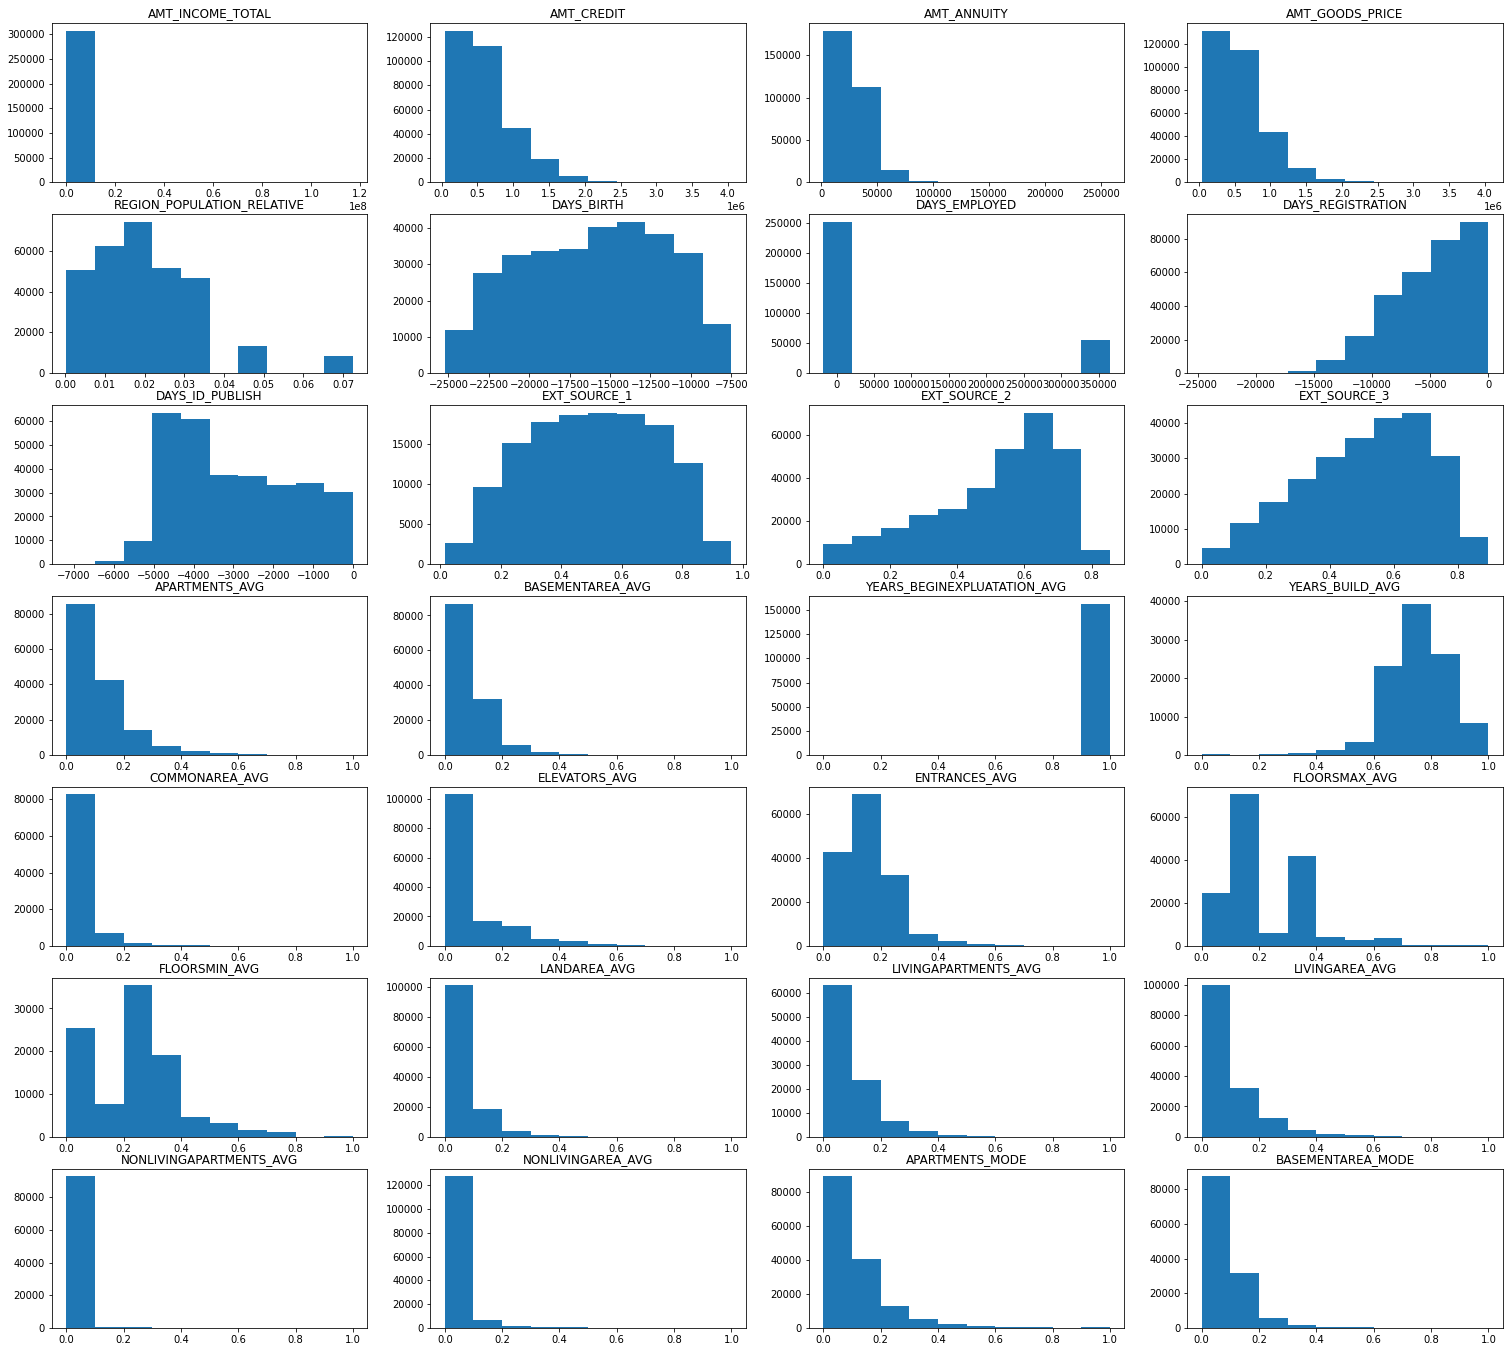

In [ ]:
plt.figure(figsize=(26, 24))
for i, col in enumerate(continuous_vars[2:30]):
    plt.subplot(7, 4, i + 1)
    plt.hist(app_train[col])
    plt.title(col)

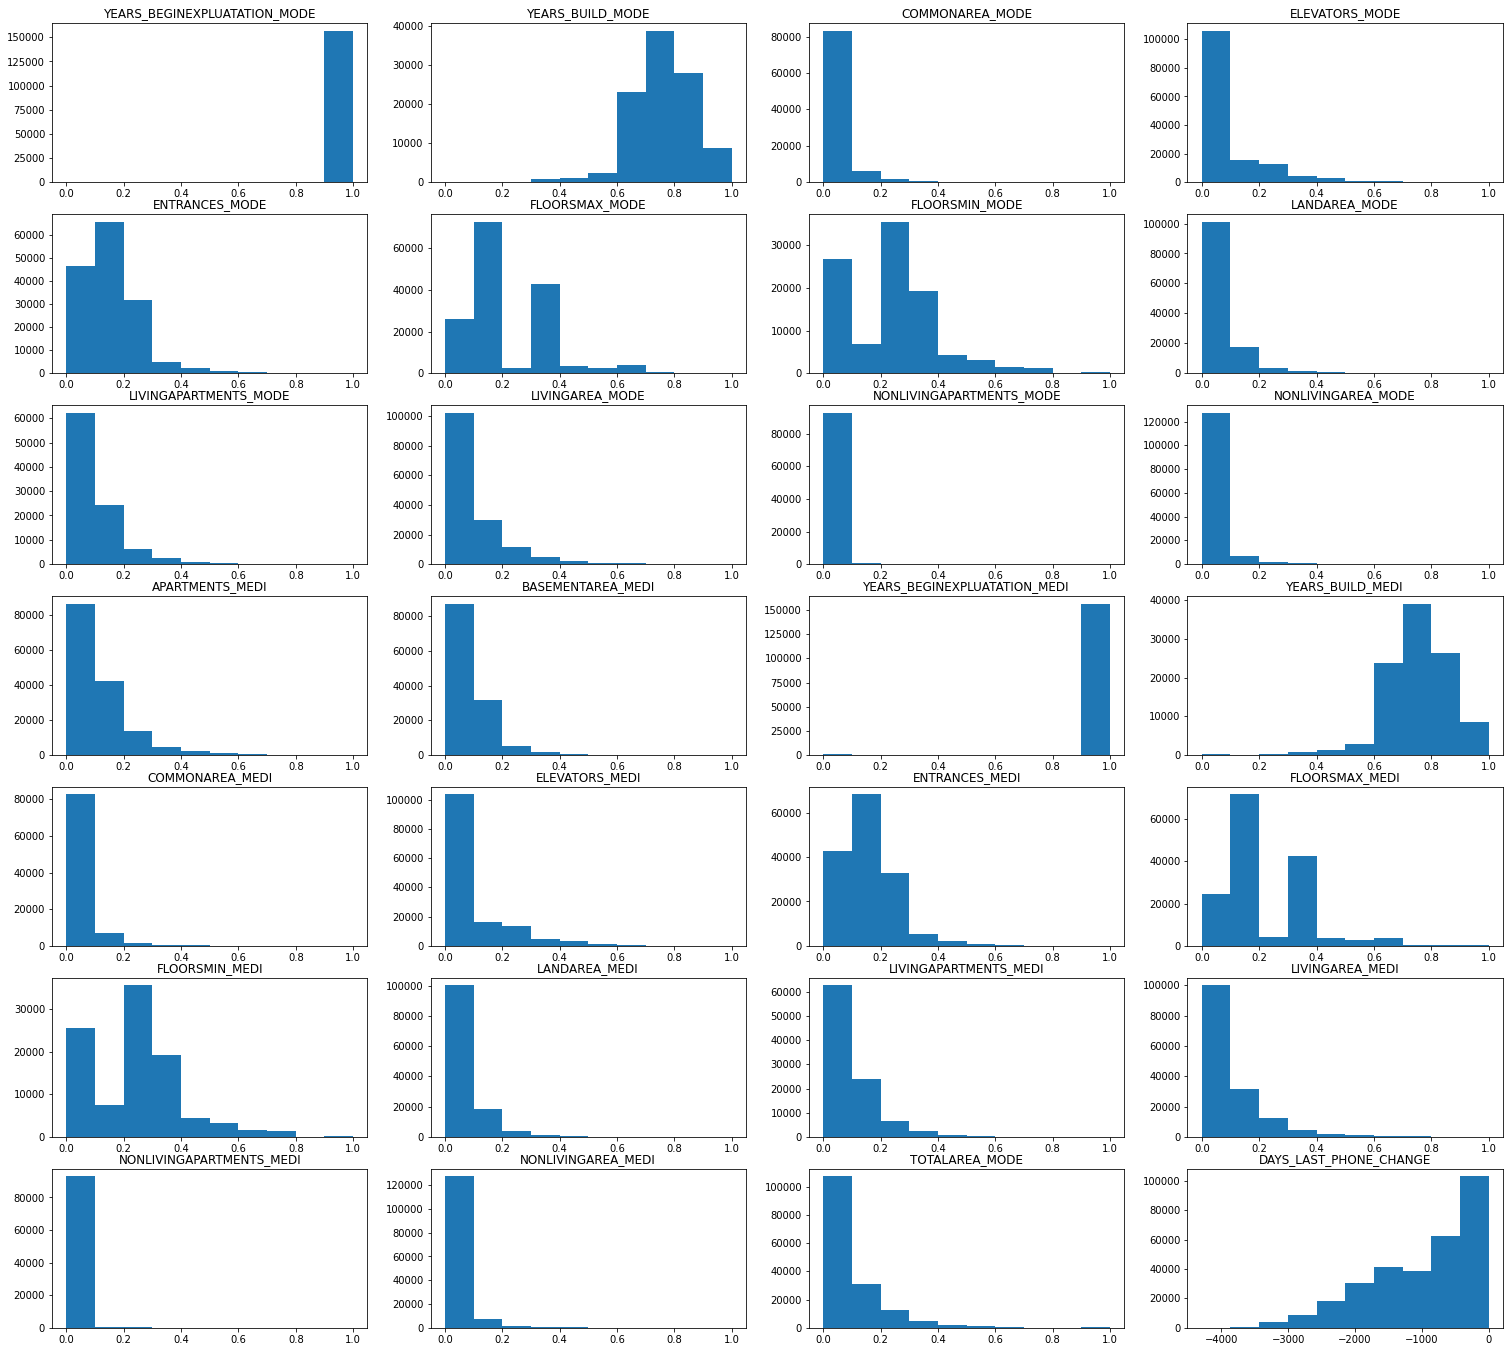

In [ ]:
plt.figure(figsize=(26, 24))
for i, col in enumerate(continuous_vars[30:]):
    plt.subplot(7, 4, i + 1)
    plt.hist(app_train[col])
    plt.title(col)

Cols to explore more:
- DAYS_EMPLOYED (seems to have some discontinuity, we need to check those)


###### DAYS_EMPLOYED

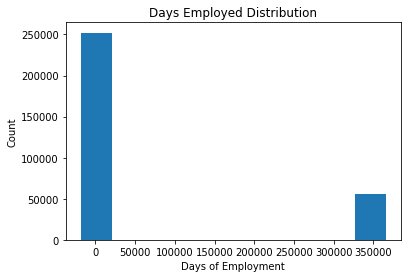

In [67]:
ax = app_train['DAYS_EMPLOYED'].plot.hist()
ax.set(xlabel="Days of Employment", ylabel='Count', title="Days Employed Distribution")
plt.show()

In [ ]:
app_train[app_train['DAYS_EMPLOYED'] > 0].shape

(55374, 122)

In [ ]:
app_train[app_train['DAYS_EMPLOYED'] > 0]['DAYS_EMPLOYED'].unique()

array([365243])

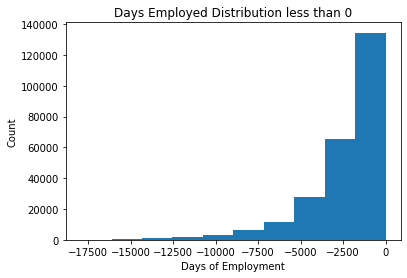

In [69]:
ax = app_train[app_train['DAYS_EMPLOYED'] <= 0]['DAYS_EMPLOYED'].plot.hist()
ax.set(xlabel="Days of Employment", ylabel='Count', title="Days Employed Distribution less than 0")
plt.show()

Values above 0 have a fixed value of 365243. \

We will check if there is a difference between clients with fixed value and those below 0 regarding TARGET variable.

In [ ]:
days_employed_chi_test = app_train.copy()
days_employed_chi_test['days_employed_anomaly'] = 1

days_employed_chi_test.loc[days_employed_chi_test['DAYS_EMPLOYED'] <= 0, 'days_employed_anomaly'] = 0
days_employed_chi_test['days_employed_anomaly'].value_counts(normalize=True)

0    0.819928
1    0.180072
Name: days_employed_anomaly, dtype: float64

H0: there is no difference between two groups \
H1: there is a difference between two groups \
Statistical Significance: 0.05 \

In [ ]:
chi_test_days_employed = stats.chi2_contingency(pd.crosstab(days_employed_chi_test.days_employed_anomaly, days_employed_chi_test.TARGET))
p = chi_test_days_employed[1]
if p < 0.05:
  print(p, " => reject H0")
else:
  print(p, " => fail to reject H0")

2.362426759854694e-143  => reject H0


Our p is close to 0, so we can reject the null hypothesis. \

We can flag the values, replace fixed value with a missing value and impute with median, or leave as is and just flag it with a binary feature.

###### DAYS_BIRTH

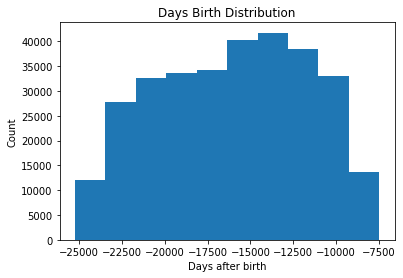

In [70]:
ax = app_train['DAYS_BIRTH'].plot.hist()
ax.set(xlabel="Days after birth", ylabel='Count', title="Days Birth Distribution")
plt.show()

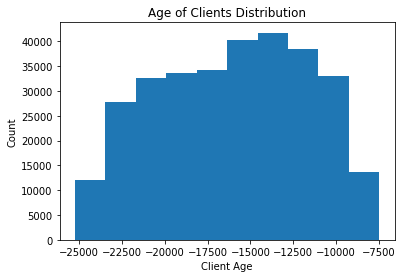

In [75]:
client_age = app_train['DAYS_BIRTH']
ax = client_age.plot.hist()
ax.set(xlabel="Client Age", ylabel='Count', title="Age of Clients Distribution")
plt.show()

It looks like clients age are between 20-70 years old.

##### Correlation

In [ ]:
correlations = app_train.corr()['TARGET'].sort_values()

In [ ]:
correlations[:20]

EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED                -0.044932
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645
REGION_POPULATION_RELATIVE   -0.037227
ELEVATORS_AVG                -0.034199
ELEVATORS_MEDI               -0.033863
FLOORSMIN_AVG                -0.033614
FLOORSMIN_MEDI               -0.033394
LIVINGAREA_AVG               -0.032997
LIVINGAREA_MEDI              -0.032739
FLOORSMIN_MODE               -0.032698
TOTALAREA_MODE               -0.032596
ELEVATORS_MODE               -0.032131
LIVINGAREA_MODE              -0.030685
AMT_CREDIT                   -0.030369
Name: TARGET, dtype: float64

In [ ]:
correlations[86:]

OBS_30_CNT_SOCIAL_CIRCLE       0.009131
CNT_FAM_MEMBERS                0.009308
CNT_CHILDREN                   0.019187
AMT_REQ_CREDIT_BUREAU_YEAR     0.019930
FLAG_WORK_PHONE                0.028524
DEF_60_CNT_SOCIAL_CIRCLE       0.031276
DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

- We will take EXT_SOURCE_X features and DAYS_BIRTH and apply PolynomialFeatures on them

### Declaring variables based on categories

We will encode categorical vars with one-hot encoding, binary variables will be encoded by dropping the extra column 

In [36]:
binary_vars = ['NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CODE_GENDER']

non_binary_vars = ['NAME_TYPE_SUITE',
                   'NAME_INCOME_TYPE' ,
                   'NAME_EDUCATION_TYPE', 
                   'NAME_FAMILY_STATUS', 
                   'NAME_HOUSING_TYPE', 
                   'OCCUPATION_TYPE', 
                   'WEEKDAY_APPR_PROCESS_START', 
                   'ORGANIZATION_TYPE', 
                   'FONDKAPREMONT_MODE', 
                   'HOUSETYPE_MODE', 
                   'WALLSMATERIAL_MODE']

non_binary_baseline = ['NAME_TYPE_SUITE',
                       'NAME_INCOME_TYPE',
                       'NAME_EDUCATION_TYPE', 
                       'NAME_FAMILY_STATUS', 
                       'NAME_HOUSING_TYPE', 
                       'WEEKDAY_APPR_PROCESS_START', 
                       'ORGANIZATION_TYPE']

cat_features_baseline = binary_vars + non_binary_baseline

non_housing_non_binary_vars = ['NAME_TYPE_SUITE',
                        'NAME_INCOME_TYPE',
                        'NAME_EDUCATION_TYPE', 
                        'NAME_FAMILY_STATUS', 
                        'NAME_HOUSING_TYPE', 
                        'OCCUPATION_TYPE', 
                        'WEEKDAY_APPR_PROCESS_START', 
                        'ORGANIZATION_TYPE']

numerical_missing = ['OWN_CAR_AGE',
                     'EXT_SOURCE_1', 
                     'EXT_SOURCE_3', 
                     'EXT_SOURCE_2',
                     'AMT_REQ_CREDIT_BUREAU_QRT', 
                     'AMT_REQ_CREDIT_BUREAU_YEAR', 
                     'AMT_REQ_CREDIT_BUREAU_HOUR',
                     'AMT_REQ_CREDIT_BUREAU_DAY',
                     'AMT_REQ_CREDIT_BUREAU_WEEK', 
                     'AMT_REQ_CREDIT_BUREAU_MON',
                     'AMT_GOODS_PRICE',
                     'AMT_ANNUITY',
                     'CNT_FAM_MEMBERS',
                     'DAYS_LAST_PHONE_CHANGE',
                     'DEF_60_CNT_SOCIAL_CIRCLE',
                     'OBS_60_CNT_SOCIAL_CIRCLE',
                     'OBS_30_CNT_SOCIAL_CIRCLE',
                     'DEF_30_CNT_SOCIAL_CIRCLE']

cat_missing = ['OCCUPATION_TYPE', 'NAME_TYPE_SUITE']

### Baseline Model

Preprocessing: \

For the baseline model, we will remove all the columns with more than 10% of missing data, the rest missing data we will drop. \

In [14]:
RANDOM_STATE = 42

In [ ]:
baseline_data = app_train.copy()

missing_cols = missing_values[missing_values['percent'] > 0.1].index.tolist()
baseline_data = baseline_data.drop(missing_cols, axis=1)

baseline_data = pd.get_dummies(baseline_data, columns=binary_vars, drop_first=True)
baseline_data = pd.get_dummies(baseline_data, columns=non_binary_baseline)

baseline_data = baseline_data.dropna()

x_train, x_val, y_train, y_val = train_test_split(baseline_data.drop(['SK_ID_CURR', 'TARGET'], axis=1),
                                                  baseline_data['TARGET'],
                                                  test_size=0.2,
                                                  random_state=RANDOM_STATE,
                                                  stratify=baseline_data['TARGET'])

In [ ]:
gbc = GradientBoostingClassifier(
    random_state=RANDOM_STATE
)

gbc.fit(x_train, y_train)
print(roc_auc_score(y_train, gbc.predict_proba(x_train)[:, 1]), 'train')
print(roc_auc_score(y_val, gbc.predict_proba(x_val)[:, 1]), 'validation')

0.7242291985116656 train
0.7164525932128779 validation


In [ ]:
xgbc = XGBClassifier(
    random_state=RANDOM_STATE
)

xgbc.fit(x_train, y_train)
print(roc_auc_score(y_train, xgbc.predict_proba(x_train)[:, 1]), 'train')
print(roc_auc_score(y_val, xgbc.predict_proba(x_val)[:, 1]), 'validation')

0.7228122547992306 train
0.7155896667942689 validation


In [ ]:
cbc = CatBoostClassifier(
    random_seed=42,
    verbose=100,
    cat_features=cat_features
    
)

cbc.fit(x_train, y_train)

In [ ]:
print(roc_auc_score(y_train, cbc.predict_proba(x_train)[:, 1]), 'train')
print(roc_auc_score(y_val, cbc.predict_proba(x_val)[:, 1]), 'validation')

0.7919629298713943 train
0.7221788618069909 validation


### Feature Engineering and Hyperparametar Tuning



In [78]:
model_experiments.drop(['Unnamed: 0'], axis=1)

,model,data_explanation,hyperparam_used,roc_auc_score_train,roc_auc_score_validation
0,GB,"Baseline data, remove all columns with missing...",default,0.724229,0.716453
1,XGB,"Baseline data, remove all columns with missing...",default,0.722812,0.715590
2,cat_boost,"Baseline data, remove all columns with missing...",default,0.791963,0.722179
3,GB,"Baseline data, remove housing info missing col...",default,0.813342,0.764907
4,XGB,"Baseline data, remove housing info missing col...",default,0.813870,0.765877
5,cat_boost,"Baseline data, remove housing info missing col...",default,0.933185,0.768101
6,GB,"Remove missing housing values, keep non housin...",default,0.758948,0.750683
7,XGB,"Remove missing housing values, keep non housin...",default,0.757594,0.750150
8,cat_boost,"Remove missing housing values, keep non housin...",default,0.828280,0.759622
9,GB,impute all missing values,default,0.758848,0.746598


### Final submission

In [ ]:
### gbc

app_train_final = app_train.copy()
app_test_final = app_test.copy()

for data in [app_train_final, app_test_final]:
  data['days_employed_distorted'] = 0
  data.loc[data['DAYS_EMPLOYED'] > 0, 'days_employed_distorted'] = 1
  data.loc[data['DAYS_EMPLOYED'] > 0, 'DAYS_EMPLOYED'] = np.nan

  data['DAYS_BIRTH'] = np.floor(data['DAYS_BIRTH'] / -365)

  data['has_missing_housing_info'] = 1
  data.loc[data[housing_normalized_missing_features].isnull().sum(axis=1) < 35, 'has_missing_housing_info'] = 0

  data['has_missing_own_car_age_info'] = 0
  data.loc[data['OWN_CAR_AGE'].isnull(), 'has_missing_own_car_age_info'] = 1

  data['has_missing_ext_source_1'] = 0
  data.loc[data['EXT_SOURCE_1'].isnull(), 'has_missing_ext_source_1'] = 1

  data['has_missing_ext_source_3'] = 0
  data.loc[data['EXT_SOURCE_3'].isnull(), 'has_missing_ext_source_3'] = 1

  data['OCCUPATION_TYPE'] = data['OCCUPATION_TYPE'].fillna('missing')
  data['FONDKAPREMONT_MODE'] = data['FONDKAPREMONT_MODE'].fillna('missing')
  data['EMERGENCYSTATE_MODE'] = data['EMERGENCYSTATE_MODE'].fillna('missing')
  data['HOUSETYPE_MODE'] = data['HOUSETYPE_MODE'].fillna('missing')
  data['WALLSMATERIAL_MODE'] = data['WALLSMATERIAL_MODE'].fillna('missing')
  data['NAME_TYPE_SUITE'] = data['NAME_TYPE_SUITE'].fillna(data['NAME_TYPE_SUITE'].mode()[0])

housing_missing_data_numerical = app_train_final[housing_normalized_missing_features].select_dtypes(include=[np.number]).columns.tolist()

data_join = app_train.append(app_test)
data_join = pd.get_dummies(data_join, columns=binary_vars, drop_first=True)
data_join = pd.get_dummies(data_join, columns=non_housing_non_binary_vars)
data_join = pd.get_dummies(data_join, columns=data_join[housing_normalized_missing_features].select_dtypes(include=[object]).columns.tolist())

app_train_final = data_join[data_join['TARGET'].notnull()]
app_test_final = data_join[data_join['TARGET'].isna()]

for data in [app_train_final, app_test_final]:
  data['DAYS_EMPLOYED'] = data['DAYS_EMPLOYED'].fillna(data['DAYS_EMPLOYED'].median())

for col in numerical_missing:
  app_train_final[col].fillna(app_train_final[col].median(), inplace=True)
  app_test_final[col].fillna(app_test_final[col].median(), inplace=True)

for col in housing_missing_data_numerical:
  app_train_final[col].fillna(app_train_final[col].median(), inplace=True)
  app_test_final[col].fillna(app_test_final[col].median(), inplace=True)

for data in [app_train_final, app_test_final]:
  data['CREDIT_ANNUITY_RATIO'] = data['AMT_CREDIT'] / (data['AMT_ANNUITY'] + 0.00001)
  data['CREDIT_INCOME_PERCENT'] = data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']
  data['ANNUITY_INCOME_PERCENT'] = data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
  data['CREDIT_TERM'] = data['AMT_ANNUITY'] / data['AMT_CREDIT']
  data['DAYS_EMPLOYED_PERCENT'] = data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']

  poly_transformer = PolynomialFeatures(degree = 3)
  poly_transformed = poly_transformer.fit_transform(data[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']])
  poly_features = pd.DataFrame(poly_transformed, columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                                              'EXT_SOURCE_3', 'DAYS_BIRTH']))
  data = data.reset_index(drop=True)
  poly_features['SK_ID_CURR'] = data['SK_ID_CURR']
  poly_features = poly_features.drop(['1', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'], axis=1)
  poly_features['SK_ID_CURR'] = data['SK_ID_CURR']
  data = pd.merge(data, poly_features, on="SK_ID_CURR")

y_train = app_train_final['TARGET']
x_train = app_train_final.drop(['SK_ID_CURR', 'TARGET'], axis=1)
app_test_final = app_test_final.drop(['SK_ID_CURR', 'TARGET'], axis=1)


In [ ]:
gbc = GradientBoostingClassifier(
    random_state=RANDOM_STATE,
    n_estimators=500
)

gbc.fit(x_train, y_train)

In [24]:
gbc_pred = gbc.predict_proba(app_test_final)[:, 1]

In [25]:
gbc_final = pd.DataFrame(app_test['SK_ID_CURR'], columns = ['SK_ID_CURR'])
gbc_final['TARGET'] = gbc_pred 

gbc_final.to_csv(r'gbc.csv', index = False)

In [ ]:
### xgbc

app_train_final = app_train.copy()
app_test_final = app_test.copy()

for data in [app_train_final, app_test_final]:
  data['days_employed_distorted'] = 0
  data.loc[data['DAYS_EMPLOYED'] > 0, 'days_employed_distorted'] = 1

  data.loc[data['DAYS_EMPLOYED'] > 0, 'DAYS_EMPLOYED'] = np.nan

  data['DAYS_BIRTH'] = np.floor(data['DAYS_BIRTH'] / -365)

  data['has_missing_housing_info'] = 1
  data.loc[data[housing_normalized_missing_features].isnull().sum(axis=1) < 35, 'has_missing_housing_info'] = 0

  data['has_missing_own_car_age_info'] = 0
  data.loc[data['OWN_CAR_AGE'].isnull(), 'has_missing_own_car_age_info'] = 1

  data['has_missing_ext_source_1'] = 0
  data.loc[data['EXT_SOURCE_1'].isnull(), 'has_missing_ext_source_1'] = 1

  data['has_missing_ext_source_3'] = 0
  data.loc[data['EXT_SOURCE_3'].isnull(), 'has_missing_ext_source_3'] = 1

  data['OCCUPATION_TYPE'] = data['OCCUPATION_TYPE'].fillna('missing')
  data['FONDKAPREMONT_MODE'] = data['FONDKAPREMONT_MODE'].fillna('missing')
  data['EMERGENCYSTATE_MODE'] = data['EMERGENCYSTATE_MODE'].fillna('missing')
  data['HOUSETYPE_MODE'] = data['HOUSETYPE_MODE'].fillna('missing')
  data['WALLSMATERIAL_MODE'] = data['WALLSMATERIAL_MODE'].fillna('missing')

data_join = app_train.append(app_test)
data_join = pd.get_dummies(data_join, columns=binary_vars, drop_first=True)
data_join = pd.get_dummies(data_join, columns=non_housing_non_binary_vars)
data_join = pd.get_dummies(data_join, columns=data_join[housing_normalized_missing_features].select_dtypes(include=[object]).columns.tolist())

  
app_train_final = data_join[data_join['TARGET'].notnull()]
app_test_final = data_join[data_join['TARGET'].isna()]

for data in [app_train_final, app_test_final]:
  data['DAYS_EMPLOYED'] = data['DAYS_EMPLOYED'].fillna(data['DAYS_EMPLOYED'].median())

  data['CREDIT_ANNUITY_RATIO'] = data['AMT_CREDIT'] / (data['AMT_ANNUITY'] + 0.00001)
  data['CREDIT_INCOME_PERCENT'] = data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']
  data['ANNUITY_INCOME_PERCENT'] = data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
  data['CREDIT_TERM'] = data['AMT_ANNUITY'] / data['AMT_CREDIT']
  data['DAYS_EMPLOYED_PERCENT'] = data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']

  data['DAYS_EMPLOYED'] = data['DAYS_EMPLOYED'].fillna(data['DAYS_EMPLOYED'].median())
  data['EXT_SOURCE_1'] = data['EXT_SOURCE_1'].fillna(data['EXT_SOURCE_1'].median())
  data['EXT_SOURCE_2'] = data['EXT_SOURCE_2'].fillna(data['EXT_SOURCE_2'].median())
  data['EXT_SOURCE_3'] = data['EXT_SOURCE_3'].fillna(data['EXT_SOURCE_3'].median())

  poly_transformer = PolynomialFeatures(degree = 3)
  poly_transformed = poly_transformer.fit_transform(data[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']])
  poly_features = pd.DataFrame(poly_transformed, columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                                              'EXT_SOURCE_3', 'DAYS_BIRTH']))

  data = data.reset_index(drop=True)
  poly_features['SK_ID_CURR'] = data['SK_ID_CURR']

  poly_features = poly_features.drop(['1', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'], axis=1)
  poly_features['SK_ID_CURR'] = data['SK_ID_CURR']

  data = pd.merge(data, poly_features, on="SK_ID_CURR")

y_train = app_train_final['TARGET']
x_train = app_train_final.drop(['SK_ID_CURR', 'TARGET'], axis=1)
app_test_final = app_test_final.drop(['SK_ID_CURR', 'TARGET'], axis=1)


In [ ]:
xgbc = XGBClassifier(
    random_state=RANDOM_STATE,
    n_estimators=500
)

xgbc.fit(x_train, y_train)

In [29]:
xgbc_pred = xgbc.predict_proba(app_test_final)[:, 1]

In [30]:
xgbc_final = pd.DataFrame(app_test['SK_ID_CURR'], columns = ['SK_ID_CURR'])
xgbc_final['TARGET'] = xgbc_pred 

xgbc_final.to_csv(r'xgbc.csv', index = False)

In [51]:
### cat_boost

app_train_final = app_train.copy()
app_test_final = app_test.copy()

for data in [app_train_final, app_test_final]:
  data['days_employed_distorted'] = 0
  data.loc[data['DAYS_EMPLOYED'] > 0, 'days_employed_distorted'] = 1
  data.loc[data['DAYS_EMPLOYED'] > 0, 'DAYS_EMPLOYED'] = np.nan

  data['DAYS_BIRTH'] = np.floor(data['DAYS_BIRTH'] / -365)

  data['has_missing_housing_info'] = 1
  data.loc[data[housing_normalized_missing_features].isnull().sum(axis=1) < 35, 'has_missing_housing_info'] = 0

  data['has_missing_own_car_age_info'] = 0
  data.loc[data['OWN_CAR_AGE'].isnull(), 'has_missing_own_car_age_info'] = 1

  data['has_missing_ext_source_1'] = 0
  data.loc[data['EXT_SOURCE_1'].isnull(), 'has_missing_ext_source_1'] = 1

  data['has_missing_ext_source_3'] = 0
  data.loc[data['EXT_SOURCE_3'].isnull(), 'has_missing_ext_source_3'] = 1

  data['OCCUPATION_TYPE'] = data['OCCUPATION_TYPE'].fillna('missing')
  data['FONDKAPREMONT_MODE'] = data['FONDKAPREMONT_MODE'].fillna('missing')
  data['EMERGENCYSTATE_MODE'] = data['EMERGENCYSTATE_MODE'].fillna('missing')
  data['HOUSETYPE_MODE'] = data['HOUSETYPE_MODE'].fillna('missing')
  data['WALLSMATERIAL_MODE'] = data['WALLSMATERIAL_MODE'].fillna('missing')
  data['NAME_TYPE_SUITE'] = data['NAME_TYPE_SUITE'].fillna(data['NAME_TYPE_SUITE'].mode()[0])
  data['CODE_GENDER'] = data['CODE_GENDER'].fillna(data['CODE_GENDER'].mode()[0])

  housing_missing_data_numerical = data[housing_normalized_missing_features].select_dtypes(include=[np.number]).columns.tolist()

  data['DAYS_EMPLOYED'] = data['DAYS_EMPLOYED'].fillna(data['DAYS_EMPLOYED'].median())

  for col in numerical_missing:
    data[col].fillna(data[col].median(), inplace=True)

  for col in housing_missing_data_numerical:
    data[col].fillna(data[col].median(), inplace=True)

  data['CREDIT_INCOME_PERCENT'] = data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']
  data['ANNUITY_INCOME_PERCENT'] = data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
  data['CREDIT_TERM'] = data['AMT_ANNUITY'] / data['AMT_CREDIT']
  data['DAYS_EMPLOYED_PERCENT'] = data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']
  data["CREDIT_ANNUITY_RATIO"] = data["AMT_CREDIT"] / (data["AMT_ANNUITY"] + 0.00001)

y_train = app_train_final['TARGET']
x_train = app_train_final.drop(['SK_ID_CURR', 'TARGET'], axis=1)
app_test_final = app_test_final.drop(['SK_ID_CURR'], axis=1)


In [44]:
cbc = CatBoostClassifier(
    random_seed=42,
    verbose=100,
)

cat_features = binary_vars + non_housing_non_binary_vars + x_train[housing_normalized_missing_features].select_dtypes(include=[object]).columns.tolist()


cbc.fit(x_train, y_train, cat_features = cat_features)


Learning rate set to 0.118919
0:	learn: 0.5733134	total: 1.21s	remaining: 20m 13s
100:	learn: 0.2432722	total: 1m 31s	remaining: 13m 32s
200:	learn: 0.2390229	total: 2m 57s	remaining: 11m 46s
300:	learn: 0.2358827	total: 4m 23s	remaining: 10m 13s
400:	learn: 0.2330558	total: 5m 53s	remaining: 8m 47s
500:	learn: 0.2304369	total: 7m 21s	remaining: 7m 19s
600:	learn: 0.2279851	total: 8m 48s	remaining: 5m 50s
700:	learn: 0.2256591	total: 10m 16s	remaining: 4m 22s
800:	learn: 0.2234237	total: 11m 42s	remaining: 2m 54s
900:	learn: 0.2213773	total: 13m 10s	remaining: 1m 26s
999:	learn: 0.2194111	total: 14m 38s	remaining: 0us


In [45]:
cbc_pred = cbc.predict_proba(app_test_final)[:, 1]

In [46]:
cbc_final = pd.DataFrame(app_test['SK_ID_CURR'], columns = ['SK_ID_CURR'])
cbc_final['TARGET'] = cbc_pred 

cbc_final.to_csv(r'cbc.csv', index = False)

In [47]:
stacked_avg = pd.DataFrame(app_test['SK_ID_CURR'], columns = ['SK_ID_CURR'])
stacked_avg['TARGET'] = (cbc_final['TARGET'] + xgbc_final['TARGET'] + gbc_final['TARGET']) / 3
stacked_avg.to_csv(r'stacked.csv', index=False)

### Final Notes

- To improve the score, we would need to explore other data sets and extract valuable features from there.

- Find optimal hyperparametars for models.

- Do feature importence on different tresholds for each model to maximize the performence.

### Kaggle Notebooks used to supplement this notebook:

- https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction
- https://www.kaggle.com/jpmiller/patterns-of-missing-data
- https://github.com/ovidijusku/sharingiscaring/blob/main/bestfeature.py